# Importacion de librerias

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import os
from scipy.optimize import minimize
import ipywidgets as widgets
import pickle
import seaborn as sns
import pandas as pd
import sys 

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

%matplotlib inline

In [2]:
# # Para hacer mas grande la ventana de scrolling de resultados
# from IPython.display import display, HTML
# display(HTML("<style>.jp-CodeCell.jp-mod-outputsScrolled .jp-Cell-outputArea { max-height: 35em; }</style>"))

# Clases y metodos auxiliares

In [3]:
class TrainModels():
    @staticmethod
    def get_points_3D_euler_angles_all_postures_list(path):
        points_3D_euler_angles_all_postures_list=[]
        files=os.listdir(path)
        files.sort()
        points_3D_files=list(filter(lambda elem: elem.split("_")[0] != 'euler', files))
        for i,points_3D_file in enumerate(points_3D_files):   
            points_3D_full_path=os.path.join(path, *[points_3D_file])
            euler_angles_full_path=os.path.join(path, *[f"euler_angles_for_classification_{str(i + 1).zfill(4)}.npy"])
            points_3D=np.load(points_3D_full_path)
            euler_angles=None
            if os.path.exists(euler_angles_full_path):
                euler_angles=np.load(euler_angles_full_path)
            points_3D_euler_angles_all_postures_list.append((points_3D,euler_angles))
        return points_3D_euler_angles_all_postures_list

    @staticmethod
    def get_data(path):
        points_3D_euler_angles_list=[]
        dict_information={}
        files=os.listdir(path)
        files.sort()
        dict_information_file_name=list(filter(lambda elem: elem.split(".")[1] == "pkl", files))
        if len(dict_information_file_name) > 0:
            with open(os.path.join(path, *[dict_information_file_name[0]]), "rb") as f:
                dict_information=pickle.load(f)
            files.remove(dict_information_file_name[0])
        points_3D_files=list(filter(lambda elem: elem.split("_")[0] != 'euler', files))
        for i,points_3D_file in enumerate(points_3D_files):            
            points_3D_full_path=os.path.join(path, *[points_3D_file])
            euler_angles_full_path=os.path.join(path, *[f"euler_angles_for_classification_{str(i + 1).zfill(4)}.npy"])
            points_3D=np.load(points_3D_full_path)
            euler_angles=None
            if os.path.exists(euler_angles_full_path):
                euler_angles=np.load(euler_angles_full_path)
            points_3D_euler_angles_list.append((points_3D,euler_angles))
        return points_3D_euler_angles_list,dict_information

    @staticmethod
    def get_X_from_euler_angles_list(euler_angles_list):
        # Por cada postura se tienen angulos de Euler de diferentes puntos 3D de dicha postura
        n= 14 * 3 
        X=np.zeros((len(euler_angles_list), n))
        for i,euler_angles in enumerate(euler_angles_list):
            # Todas las filas de 'euler_angles' pasan a ser una sola fila
            X[i]=euler_angles.flatten(order='C')
        return X
        
    @staticmethod
    def delete_negative_postures_from_all_postures(X_positive, X_negative, t=0.75, rate=0.01):
        # t: Porcentaje de datos que debe estar dentro de la hiperesfera
        # rate: Tasa a la que aumentara el radio de la hiperesfera
        
        # Centroide de los ejemplos positivos
        centroid=np.mean(X_positive, axis=0)
        m,n=X_positive.shape
        # Funcion para evaluar un punto en la hiperesfera
        hypersphere_evaluation=lambda p,o,r: (np.linalg.norm(p - o) ** 2) - r ** 2
        
        # Busqueda del valor de 'r' para el cual el 't' % de los ejemplos positivos se encuentran dentro de la hiperesfera
        r=rate
        while True:
            count=0
            for i in range(m):
                p=X_positive[i]
                count+=int(hypersphere_evaluation(p,centroid,r) <= 0)
            t_current=count / m
            if t_current >= t:
                break
            else:
                r+=rate
    
        print(f"Valor final de r: {r}")
        
        # Eliminacion de ejemplos negativos que estan muy cercas de los ejemplos positivos
        m,n=X_negative.shape
        indexes_to_delete=[]
        for i in range(m):
            p=X_negative[i]
            if hypersphere_evaluation(p,centroid,r) <= 0:
                indexes_to_delete.append(i)
        new_X_negative=np.delete(X_negative, indexes_to_delete, axis=0)
        
        return new_X_negative

    @staticmethod
    def get_indexes_outliers(data):
        """
        El percentil es una medida de posición usada en estadística que indica, 
        una vez ordenados los datos de menor a mayor, el valor de la variable 
        por debajo del cual se encuentra un porcentaje dado de observaciones en un grupo.
        """
        
        # Mediana de los datos
        median=np.median(data)
        # Valor debajo del cual se encuentra el 25% de los datos
        Q1=np.percentile(data, 25, method='linear')
        # Valor debajo del cual se encuentra el 75% de los datos
        Q3=np.percentile(data, 75, method='linear')
        # 50% de los datos (si IQR es grande, implica que existe mucha dispersion de los datos)
        IQR=Q3 - Q1
        min_val=data.min()
        max_val=data.max()
        L_left=np.max([min_val, Q1 - 1.5 * IQR])
        L_right=np.min([max_val, Q3 + 1.5 * IQR])
        d={
            "median": median,
            "Q1": Q1,
            "Q3": Q3,
            "IQR": IQR,
            "min": min_val,
            "max": max_val,
            "L_left": L_left,
            "L_right": L_right
        }
    
        indexes_outliers=[]
        indexes_outliers.extend(np.where(data < L_left)[0])
        indexes_outliers.extend(np.where(data > L_right)[0])
        indexes_outliers.sort()
        return indexes_outliers,d

    @staticmethod
    def delete_outliers(X):
        # Si alguna caracteristica tiene un outlier, se eliminara la fila correspondiente
        m,n=X.shape
        all_indexes_outliers=[]
        for i in range(n):
            indexes_outliers,_=TrainModels.get_indexes_outliers(X[:,i])
            all_indexes_outliers.extend(indexes_outliers)
        all_indexes_outliers=list(set(all_indexes_outliers))
        all_indexes_outliers.sort()
        
        print(f"Se eliminaron {len(all_indexes_outliers)} ejemplos de {X.shape[0]} ({(len(all_indexes_outliers) / X.shape[0]) * 100} %)")
    
        new_X=np.delete(X, all_indexes_outliers, axis=0)
        return new_X,all_indexes_outliers

    @staticmethod
    def get_weights_binary_classification(y):
        n_positive=np.sum(y == 1)
        n_negative=np.sum(y == 0)
        alpha_positive=n_negative / n_positive
        alpha_negative=1
        weights={"0": alpha_negative, "1": alpha_positive}
        return weights

In [4]:
# Para graficar puntos 3D
def get_points_3D_figure(points_3D, algorithm_point_names_list, algorithm_connection_list, rotation=1.25, title=""):
    # Puntos 3D
    data=[
        go.Scatter3d(
            x=points_3D[:,0], 
            y=points_3D[:,1], 
            z=points_3D[:,2], 
            mode="markers", 
            name="",
            marker=dict(size=6, symbol="circle", color="red"),
            text=[f"{algorithm_point_names_list[i]} ({i})" for i in range(len(algorithm_point_names_list))]
        )
    ]
    # Conexion entre puntos 3D
    for connection in algorithm_connection_list:
        c1,c2=connection
        x1,y1,z1=points_3D[c1]
        x2,y2,z2=points_3D[c2]
        data.append(
            go.Scatter3d(
                x=[x1,x2], 
                y=[y1,y2], 
                z=[z1,z2], 
                mode="lines", 
                name="",
                line=dict(width=5, color='green')
            )
        )
    fig = go.Figure(data=data)
    fig.update_layout(
        scene=dict(
            xaxis_title='x',
            yaxis_title='y',
            zaxis_title='z',
            xaxis = dict(nticks=4, range=[-1.5,1.5]),
            yaxis = dict(nticks=4, range=[-1.5,1.5]),
            zaxis = dict(nticks=4, range=[-1.5,1.5]),
            aspectratio=dict(x=1, y=1, z=1)
        ),
        title=dict(text=title), 
        autosize=False,
        width=800, 
        height=500,
        margin=dict(l=40, r=40, b=40, t=40),
        showlegend=False,
        legend=dict(
            yanchor="top",
            y=0.99,
            xanchor="left",
            x=0.01,
            font=dict(
                family="Courier",
                size=14,
                color="black"
            ),
            itemsizing="constant"
        ),
        scene_camera=dict(
            up=dict(x=0, y=0, z=1),
            center=dict(x=0, y=0, z=0),
            eye=dict(x=rotation, y=1.25, z=2)
        )
    )
    return fig

In [5]:
# Para interactuar con la grafica de puntos 3D
def interact_posture_figure(index, rotation, points_3D_list, algorithm_point_names_list, algorithm_connection_list):
    points_3D=points_3D_list[index]
    fig=get_points_3D_figure(points_3D, algorithm_point_names_list, algorithm_connection_list, rotation, title="")
    fig.show()

In [6]:
# Para graficar la matriz de confusion
def plot_confusion_matrix(cm):
    k=cm.shape[0]
    # Grafica de la matriz de confusion
    df_confusion_matrix = pd.DataFrame(cm, range(k), range(k)) 
    sns.heatmap(df_confusion_matrix, annot=True, fmt=".0f", cmap="Reds", annot_kws={"size": 16}) # font size
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.show()

# Informacion del algoritmo utilizado

In [7]:
algorithm_number_points=33
algorithm_connection_list=[(0,1),(1,2),(2,3),(3,7),(0,4),(4,5),(5,6),(6,8),(9,10),(11,13),(13,15),(15,21),(15,19),(19,17),(17,15),(12,14),(14,16),(16,22),(16,20),(20,18),(18,16),(11,23),(23,24),(24,12),(12,11),(23,25),(25,27),(27,31),(31,29),(29,27),(24,26),(26,28),(28,32),(32,30),(30,28)]
algorithm_point_names_list=[
    "nose",
    "left_eye_inner", "left_eye", "left_eye_outer",
    "right_eye_inner", "right_eye", "right_eye_outer",
    "left_ear", "right_ear",
    "mouth_left", "mouth_right",
    "left_shoulder", "right_shoulder",
    "left_elbow", "right_elbow",
    "left_wrist", "right_wrist",
    "left_pinky_1", "right_pinky_1",
    "left_index_1", "right_index_1",
    "left_thumb_2", "right_thumb_2",
    "left_hip", "right_hip",
    "left_knee", "right_knee",
    "left_ankle", "right_ankle",
    "left_heel", "right_heel",
    "left_foot_index", "right_foot_index"
]

# Directorio de datos
- data
    - datasets
        - all_postures
        - movement_posture_XXXX
            - movement_posture_XXXX.pkl (diccionario de informacion)
            - movement_posture_XXXX_XXXX.npy
            - ...
            - euler_angles_for_classification_XXX.npy
            - ...
        - ...
        - neutral_posture_XXXX
            - neutral_posture_XXXX.pkl (diccionario de informacion)
            - neutral_posture_XXXX_XXXX.npy
            - ...
            - euler_angles_for_classification_XXX.npy
            - ...
        - ...
    - models
        - model_movement_posture_XXXX
            - data.npy (parametros entrenados)
        - ...
        - model_neutral_posture_XXXX
            - data.npy (parametros entrenados)
        - ...

In [8]:
current_path=os.path.dirname(os.path.abspath('__file__')) 
print(current_path)

/home/chuy/Practicas/PORTAFOLIO/CERTIFICADOS/Samsung Innovation Campus 2024/Proyecto/NEW PROJECT/Notebooks


In [9]:
datasets_path=os.path.join("/".join(current_path.split("/")[0:-1]), *["Project", "app", "data", "datasets"])
print(datasets_path)

/home/chuy/Practicas/PORTAFOLIO/CERTIFICADOS/Samsung Innovation Campus 2024/Proyecto/NEW PROJECT/Project/app/data/datasets


In [10]:
folder_names_neutral_posture=list(filter(lambda elem: elem.split('_')[0] == 'neutral', os.listdir(datasets_path)))
folder_names_movement_posture=list(filter(lambda elem: elem.split('_')[0] == 'movement', os.listdir(datasets_path)))
folder_names_neutral_posture.sort()
folder_names_movement_posture.sort()
print("Posturas neutrales:")
for i in range(len(folder_names_neutral_posture)):
    print(f"\t- Postura: {folder_names_neutral_posture[i]} (indice: {i})")
print("Posturas de movimiento:")
for i in range(len(folder_names_movement_posture)):
    print(f"\t- Postura: {folder_names_movement_posture[i]} (indice: {i})")

Posturas neutrales:
	- Postura: neutral_posture_0001 (indice: 0)
Posturas de movimiento:
	- Postura: movement_posture_0001 (indice: 0)
	- Postura: movement_posture_0002 (indice: 1)
	- Postura: movement_posture_0003 (indice: 2)


# Posturas aleatorias

In [11]:
points_3D_euler_angles_all_postures_list=TrainModels.get_points_3D_euler_angles_all_postures_list(os.path.join(datasets_path, *["all_postures"]))
points_3D_all_postures_list=[points_3D_euler_angles_all_postures_list[i][0] for i in range(len(points_3D_euler_angles_all_postures_list))]
euler_angles_all_postures_list=[points_3D_euler_angles_all_postures_list[i][1] for i in range(len(points_3D_euler_angles_all_postures_list))]
print(f"Total de posturas aleatorias: {len(points_3D_euler_angles_all_postures_list)}")

Total de posturas aleatorias: 888


In [12]:
index_slider=widgets.IntSlider(min=0, max=len(points_3D_all_postures_list) - 1, step=1, value=0)
rotation_slider=widgets.FloatSlider(min=-1.5, max=1.5, step=0.1, value=-1)
widgets.interact(lambda index,rotation: interact_posture_figure(
    index, 
    rotation, 
    points_3D_all_postures_list, 
    algorithm_point_names_list, 
    algorithm_connection_list,
), index=index_slider, rotation=rotation_slider)

interactive(children=(IntSlider(value=0, description='index', max=887), FloatSlider(value=-1.0, description='r…

<function __main__.<lambda>(index, rotation)>

# Seleccion de carpeta

In [13]:
# UTILIZAR SOLO UNO

# Seleccion de postura neutral
# neutral_posture_index=0
# selected_posture_name=folder_names_neutral_posture[neutral_posture_index]
# specific_full_path=os.path.join(datasets_path, *[selected_posture_name])

# Seleccion de postura de movimiento
movement_posture_index=2
selected_posture_name=folder_names_movement_posture[movement_posture_index]
specific_full_path=os.path.join(datasets_path, *[selected_posture_name])

print(specific_full_path)

/home/chuy/Practicas/PORTAFOLIO/CERTIFICADOS/Samsung Innovation Campus 2024/Proyecto/NEW PROJECT/Project/app/data/datasets/movement_posture_0003


# Obtencion de los puntos 3D, de los angulos de Euler para la clasificacion y de la informacion de dicha postura

In [14]:
points_3D_euler_angles_list,dict_information=TrainModels.get_data(specific_full_path)
points_3D_list=[points_3D_euler_angles_list[i][0] for i in range(len(points_3D_euler_angles_list))]
euler_angles_list=[points_3D_euler_angles_list[i][1] for i in range(len(points_3D_euler_angles_list))]
print(f"Total de datos: {len(points_3D_euler_angles_list)}")
print(dict_information)

Total de datos: 204
{'name': 'Postura de movimiento 3', 'description': 'Brazos levantados a los lados\n'}


# Grafica puntos 3D

In [15]:
index_slider=widgets.IntSlider(min=0, max=len(points_3D_list) - 1, step=1, value=0)
rotation_slider=widgets.FloatSlider(min=-1.5, max=1.5, step=0.1, value=-1)
widgets.interact(lambda index,rotation: interact_posture_figure(
    index, 
    rotation, 
    points_3D_list, 
    algorithm_point_names_list, 
    algorithm_connection_list,
), index=index_slider, rotation=rotation_slider)

interactive(children=(IntSlider(value=0, description='index', max=203), FloatSlider(value=-1.0, description='r…

<function __main__.<lambda>(index, rotation)>

# Limpieza de datos
Debido al ruido que se puede introducir al tomar datos de posturas, se procede a eliminar aquellas posturas que no pertenezcan a la verdadera postura.

Se utilizaran los angulos de Euler para esta tarea.

Se eliminaran todos los ejemplos que tengan valores atipicos (dados por el boxplot).

In [16]:
X_positive=TrainModels.get_X_from_euler_angles_list(euler_angles_list)
print(X_positive.shape)

(204, 42)


In [17]:
columns_df=[]
angle_names=["x","y","z"]
for i in range(7):
    for j in range(3):
        columns_df.append(f"left_{i + 1}_angle_{angle_names[j]}")
for i in range(7):
    for j in range(3):
        columns_df.append(f"right_{i}_angle_{angle_names[j]}")
df_positive=pd.DataFrame(X_positive, columns=columns_df)
df_positive.head()

,left_1_angle_x,left_1_angle_y,left_1_angle_z,left_2_angle_x,left_2_angle_y,left_2_angle_z,left_3_angle_x,left_3_angle_y,left_3_angle_z,left_4_angle_x,left_4_angle_y,left_4_angle_z,left_5_angle_x,left_5_angle_y,left_5_angle_z,left_6_angle_x,left_6_angle_y,left_6_angle_z,left_7_angle_x,left_7_angle_y,left_7_angle_z,right_0_angle_x,right_0_angle_y,right_0_angle_z,right_1_angle_x,right_1_angle_y,right_1_angle_z,right_2_angle_x,right_2_angle_y,right_2_angle_z,right_3_angle_x,right_3_angle_y,right_3_angle_z,right_4_angle_x,right_4_angle_y,right_4_angle_z,right_5_angle_x,right_5_angle_y,right_5_angle_z,right_6_angle_x,right_6_angle_y,right_6_angle_z
0,-0.282854,0.520266,0.936610,0.103655,-0.026366,0.021798,0.482922,-1.289639,-0.399694,-0.183801,0.137312,-0.208784,0.017950,0.078414,-0.276978,-0.374774,1.303561,-0.253930,0.389279,-0.656952,0.467825,0.515799,1.083058,-0.443628,-0.073702,-0.122726,0.028045,0.652992,-1.202352,-0.791514,0.310482,0.132943,0.148008,0.295081,0.000454,-0.111102,0.336781,1.262858,0.582493,-2.931395,1.128094,-0.618092
1,-0.465054,0.471689,0.999159,-0.067062,-0.105579,-0.031590,0.421394,-1.264977,-0.255807,-0.138844,0.176893,-0.153958,-0.089955,-0.033443,-0.069879,-0.568572,1.238694,-0.465928,0.617957,-0.502632,0.278742,1.210709,0.935478,0.247640,-0.030183,-0.106508,-0.029785,0.419913,-1.252163,-0.605408,0.337262,0.095794,0.182888,0.037940,-0.067364,0.512522,0.505381,1.237752,0.663356,-2.606398,0.977838,-0.350475
2,-0.165397,0.960927,1.787262,0.028356,-0.010666,-0.106536,0.315122,-1.280803,-0.140622,-0.244545,0.088222,-0.232383,0.048720,0.046763,-0.436887,-0.582728,1.239149,-0.516527,0.532254,-0.461067,0.304337,0.400768,0.854022,-0.132467,0.023253,-0.114523,-0.117187,0.644991,-1.186747,-0.793843,0.449824,0.049375,0.196619,0.003891,0.048889,0.299233,0.342623,1.247300,0.598160,-2.498771,0.980733,-0.235584
3,-0.727300,-0.852790,-0.448073,0.139239,0.003636,0.071278,0.435195,-1.214404,-0.345023,-0.235815,0.133567,-0.230459,0.053426,-0.010535,1.105075,-0.332700,1.229478,-0.195790,0.576481,-0.486111,0.259189,0.203803,1.016712,-0.768128,-0.099023,-0.118609,0.077243,0.676167,-1.161131,-0.798453,0.437056,0.062884,0.203910,0.134430,-0.123174,0.829415,0.239172,1.245311,0.517225,-2.500751,1.077408,-0.152142
4,-0.417702,0.461166,1.056650,0.047924,-0.047418,0.052192,0.224130,-1.208214,-0.051755,-0.300490,0.089006,-0.248343,0.145185,-0.010340,0.255876,-0.468017,1.172892,-0.417430,0.457865,-0.457655,0.395131,0.011382,1.043170,-0.918258,-0.054642,-0.110266,0.057693,0.448543,-1.124233,-0.676554,0.412301,0.067798,0.165651,0.064692,-0.327762,1.009848,0.413409,1.131893,0.656005,-2.714477,1.144679,-0.401011


Valor minimo: -1.15814200644722
Valor maximo: 0.5154497441525507
Mediana: -0.21353688637505558
IQR: 0.47786497663092936
Q1 (25%): -0.48128303278398926
Q3 (75%): -0.003418056153059928
L_left: -1.15814200644722
L_right: 0.5154497441525507


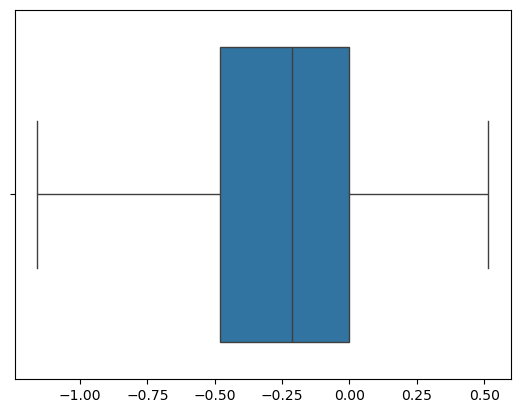

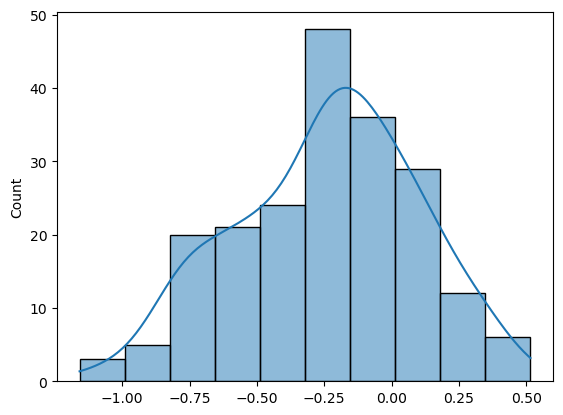

In [18]:
# Ejemplo con una caracteristica
data=X_positive[:,0]

_,d=TrainModels.get_indexes_outliers(data)

print(f"Valor minimo: {d['min']}")
print(f"Valor maximo: {d['max']}")
print(f"Mediana: {d['median']}")
print(f"IQR: {d['IQR']}")
print(f"Q1 (25%): {d['Q1']}")
print(f"Q3 (75%): {d['Q3']}")
print(f"L_left: {d['L_left']}")
print(f"L_right: {d['L_right']}")

sns.boxplot(x=data)
plt.show()

sns.histplot(x=data, bins=10, kde=True)
plt.show()

<img
  style="display: flex; margin: auto;"
  src="https://media.licdn.com/dms/image/v2/D4E12AQFLeiPQLAUGsQ/article-cover_image-shrink_720_1280/article-cover_image-shrink_720_1280/0/1681646557218?e=2147483647&v=beta&t=xsY9PaSHracABLZ5dipUvaur6fzlvvwKBWa1VWl5Gt8"
  width="700"
  height="700" 
/>

In [19]:
# Se eliminan todos los ejemplos que presenten outliers (basado en un boxplot)
X_positive,all_indexes_outliers=TrainModels.delete_outliers(X_positive)
print(X_positive.shape)

Se eliminaron 105 ejemplos de 204 (51.470588235294116 %)
(99, 42)


In [20]:
temp_points_3D_list=[]
temp_euler_angles_list=[]
for i in range(len(points_3D_list)):
    if i not in all_indexes_outliers:
        temp_points_3D_list.append(points_3D_list[i])
        temp_euler_angles_list.append(euler_angles_list[i])
points_3D_list=temp_points_3D_list
euler_angles_list=temp_euler_angles_list

# Grafica de puntos 3D limpios

In [21]:
index_slider=widgets.IntSlider(min=0, max=len(points_3D_list) - 1, step=1, value=0)
rotation_slider=widgets.FloatSlider(min=-1.5, max=1.5, step=0.1, value=-1)
widgets.interact(lambda index,rotation: interact_posture_figure(
    index, 
    rotation, 
    points_3D_list, 
    algorithm_point_names_list, 
    algorithm_connection_list,
), index=index_slider, rotation=rotation_slider)

interactive(children=(IntSlider(value=0, description='index', max=98), FloatSlider(value=-1.0, description='ro…

<function __main__.<lambda>(index, rotation)>

# Creacion del conjunto de datos
Solo se utilizan los angulos de Euler.

Los ejemplos negativos se tomaran de todas las posturas aleatorias. 

Se hara limpieza de ejemplos negativos (no se tomaran en cuenta aquellos ejemplos negativos que sean similares a los ejemplos positivos).

Debido a como se obtuvieron los datos de la clase negativa (posturas aleatorias), es posible que existan puntos de la clase negativa que estan muy cercas de la nube de puntos de la clase positiva.

NOTAS:
- Por la naturaleza de la clase positiva, su nube de puntos vive aprox. en una hiperesfera
- Por la naturaleza de la clase negativa, su nube de puntos puede ser muy compleja 

Estrategia planteada:
- Para la clase positiva, encontrar su centroide
- Crear una hiperesfera muy pequeña centrada en el centroide
- Expandir la hiperesfera de poco a poco hasta que un cierto porcentaje de ejemplos de la clase positiva esten dentro de la hiperesfera
    - El porcentaje es algo que nosotros tenemos que definir (hiperparametro)
- Eliminar todos los puntos de la clase negativa que se encuentren dentro de la hiperesfera (no se tomaran en cuenta como ejemplos de la clase negativa) 

In [22]:
X_negative=TrainModels.get_X_from_euler_angles_list(euler_angles_all_postures_list)
X_positive=TrainModels.get_X_from_euler_angles_list(euler_angles_list)
print(X_negative.shape)
print(X_positive.shape)

(888, 42)
(99, 42)


In [23]:
X_negative=TrainModels.delete_negative_postures_from_all_postures(X_positive, X_negative, t=0.75, rate=0.01)
print(X_negative.shape)

Valor final de r: 1.8300000000000014
(888, 42)


In [24]:
X=np.concatenate([X_positive, X_negative], axis=0)
y=np.concatenate([np.ones(X_positive.shape[0]), np.zeros(X_negative.shape[0])]).astype(int)
print(X.shape)
print(y.shape)

(987, 42)
(987,)


# Visualizacion de los datos

In [25]:
# DataFrame del conjunto de datos
df=pd.DataFrame(np.concatenate([X, y[:,None]], axis=1), columns=columns_df + ['class'])
df=df.astype({'class': 'int'})
df.head()

,left_1_angle_x,left_1_angle_y,left_1_angle_z,left_2_angle_x,left_2_angle_y,left_2_angle_z,left_3_angle_x,left_3_angle_y,left_3_angle_z,left_4_angle_x,left_4_angle_y,left_4_angle_z,left_5_angle_x,left_5_angle_y,left_5_angle_z,left_6_angle_x,left_6_angle_y,left_6_angle_z,left_7_angle_x,left_7_angle_y,left_7_angle_z,right_0_angle_x,right_0_angle_y,right_0_angle_z,right_1_angle_x,right_1_angle_y,right_1_angle_z,right_2_angle_x,right_2_angle_y,right_2_angle_z,right_3_angle_x,right_3_angle_y,right_3_angle_z,right_4_angle_x,right_4_angle_y,right_4_angle_z,right_5_angle_x,right_5_angle_y,right_5_angle_z,right_6_angle_x,right_6_angle_y,right_6_angle_z,class
0,-0.282854,0.520266,0.936610,0.103655,-0.026366,0.021798,0.482922,-1.289639,-0.399694,-0.183801,0.137312,-0.208784,0.017950,0.078414,-0.276978,-0.374774,1.303561,-0.253930,0.389279,-0.656952,0.467825,0.515799,1.083058,-0.443628,-0.073702,-0.122726,0.028045,0.652992,-1.202352,-0.791514,0.310482,0.132943,0.148008,0.295081,0.000454,-0.111102,0.336781,1.262858,0.582493,-2.931395,1.128094,-0.618092,1
1,-0.165397,0.960927,1.787262,0.028356,-0.010666,-0.106536,0.315122,-1.280803,-0.140622,-0.244545,0.088222,-0.232383,0.048720,0.046763,-0.436887,-0.582728,1.239149,-0.516527,0.532254,-0.461067,0.304337,0.400768,0.854022,-0.132467,0.023253,-0.114523,-0.117187,0.644991,-1.186747,-0.793843,0.449824,0.049375,0.196619,0.003891,0.048889,0.299233,0.342623,1.247300,0.598160,-2.498771,0.980733,-0.235584,1
2,0.273676,1.385730,2.223374,0.103202,0.015093,0.058375,0.516675,-1.292329,-0.376253,-0.261802,0.047914,-0.264908,0.012204,0.121186,-0.440128,-0.567254,1.283475,-0.446084,0.518913,-0.513838,0.218042,0.647342,1.240797,-0.224966,-0.079502,-0.136248,0.059620,0.716719,-1.256027,-0.896908,0.348222,0.072932,0.179542,0.088816,-0.158189,0.768198,0.571975,1.289489,0.801087,-2.545108,0.905026,-0.153414,1
3,0.038146,0.530745,1.419974,0.054189,-0.109420,-0.017385,0.285017,-1.336366,-0.200989,-0.309273,0.062106,-0.290186,0.160595,0.062200,0.404524,-0.380513,1.328337,-0.323810,0.468133,-0.547441,0.231903,0.176125,0.767560,-0.741295,-0.035334,-0.113471,-0.011656,0.553066,-1.223678,-0.668888,0.386800,0.059104,0.225370,0.076194,0.117795,-1.110181,0.282715,1.264594,0.483530,-2.576023,0.974908,-0.184551,1
4,-0.004717,0.936439,1.751773,0.000948,-0.102903,-0.062405,0.635934,-1.327157,-0.557604,-0.101726,0.167738,-0.132659,-0.086930,-0.021506,-0.680719,-0.437695,1.354843,-0.300207,0.334427,-0.630694,0.361479,-0.000197,0.391710,-0.834403,0.122033,-0.010413,-0.073386,0.561357,-1.273455,-0.637923,0.244715,0.158635,0.129952,0.252241,-0.135596,0.217742,0.215800,1.314080,0.384572,-3.033924,1.063046,-0.529942,1


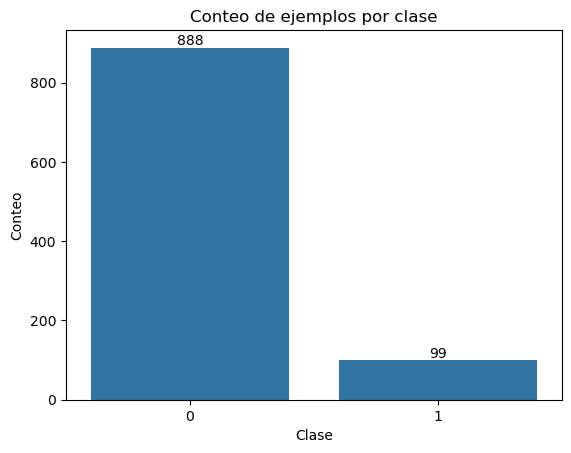

In [26]:
# Distribucion de clases
ax = sns.barplot(df, x="class", y="class", estimator="count", errorbar=None)
ax.bar_label(ax.containers[0], fontsize=10);
plt.title('Conteo de ejemplos por clase')
plt.xlabel('Clase')
plt.ylabel('Conteo')
plt.show()

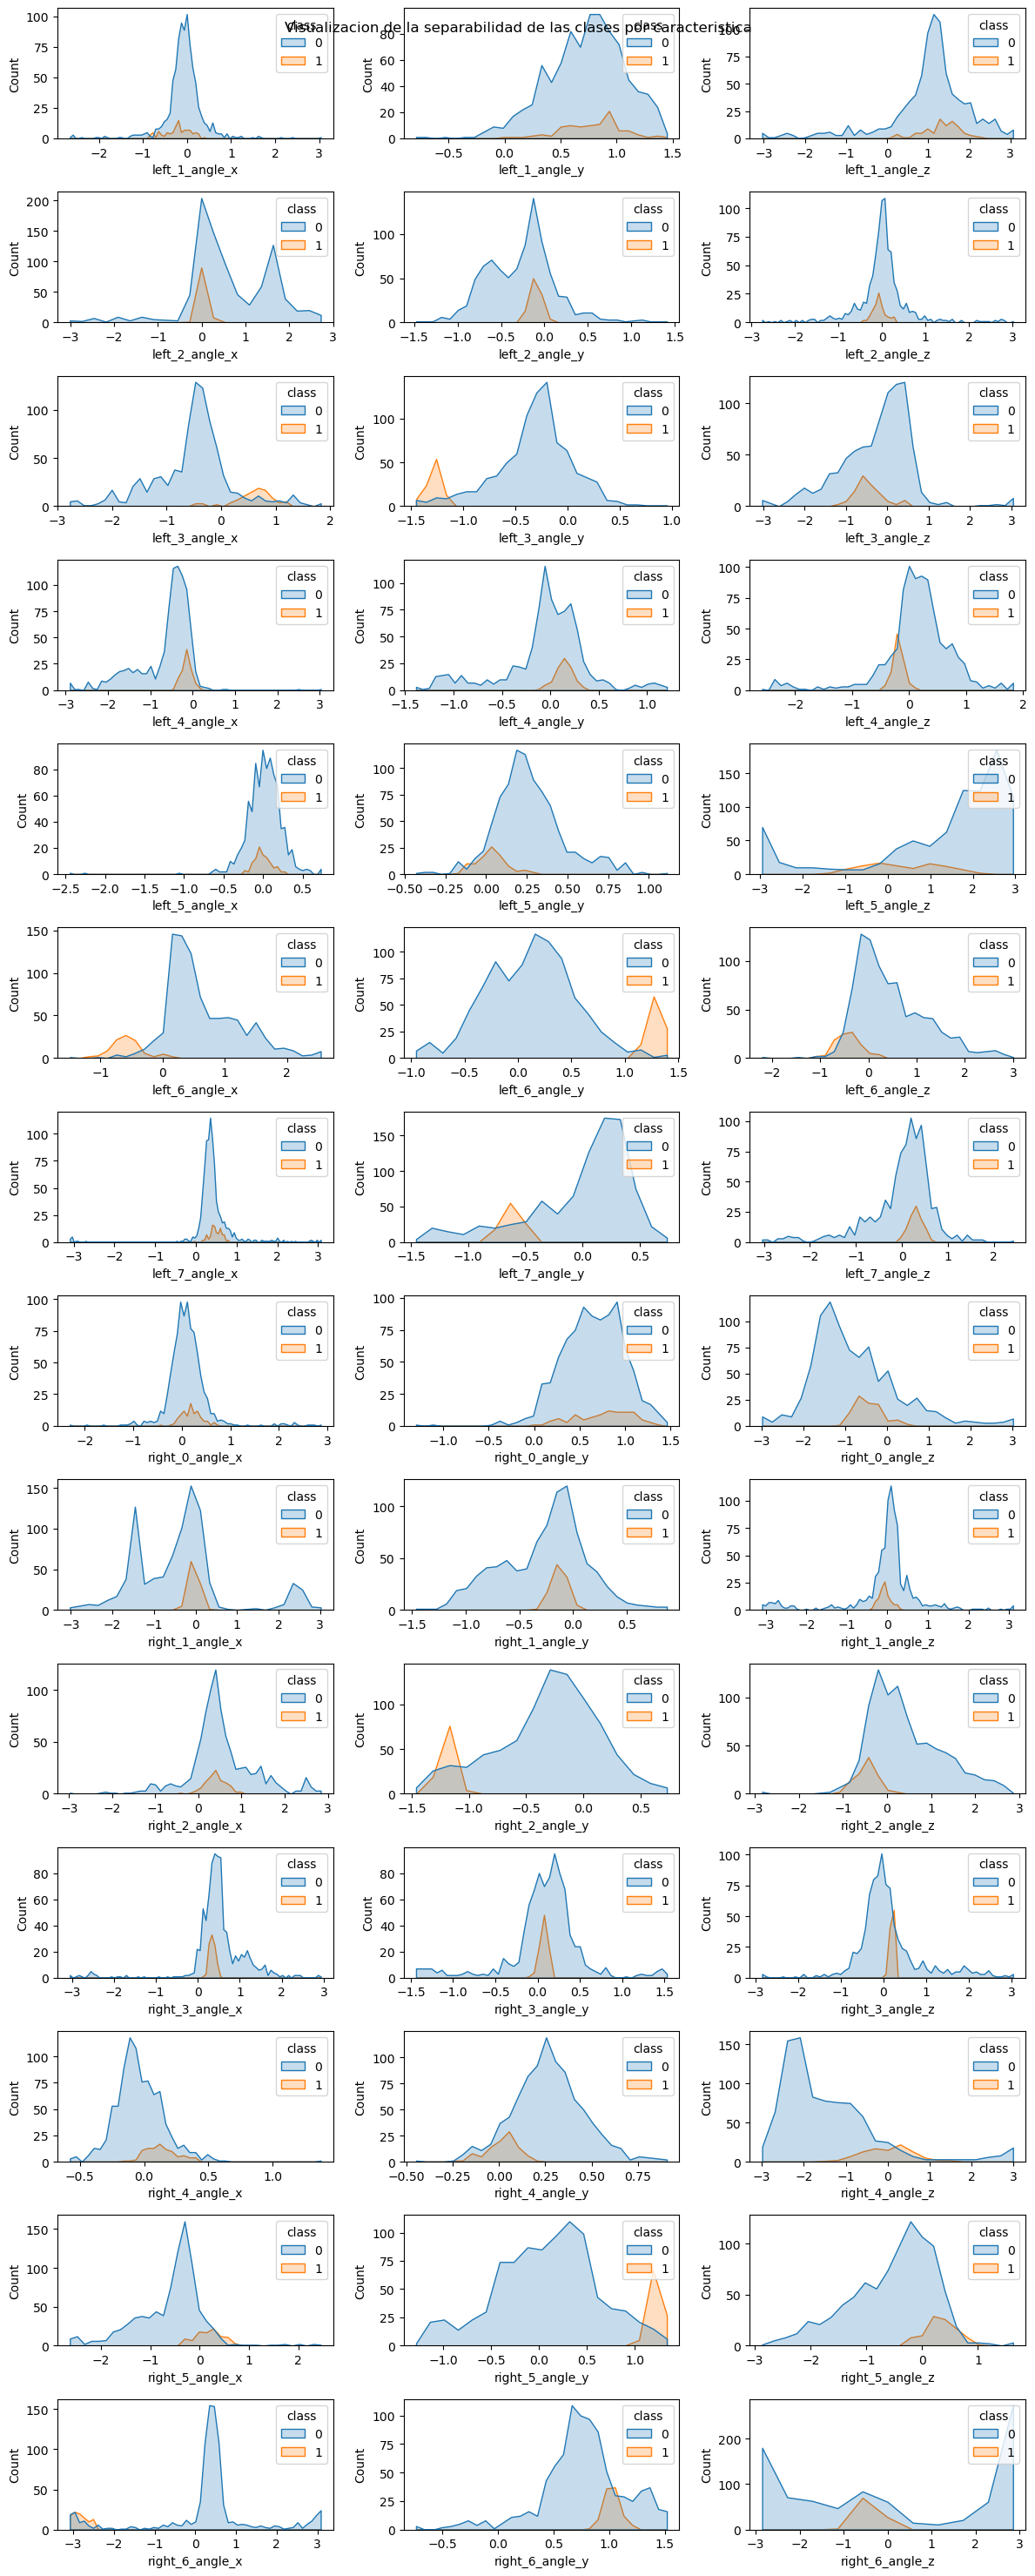

In [27]:
# Visualizacion de la separabilidad de las clases por caracteristica
# Comportamiento de cada caracteristica por clase
m,n=X.shape
n_cols=3
n_rows=int(np.ceil(n / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 30))
index=0
for row in range(n_rows):
    for col in range(n_cols):
        if index < n:
            sns.histplot(df, x=columns_df[index], hue="class", element="poly", ax=axes[row,col])
            index+=1
fig.suptitle('Visualizacion de la separabilidad de las clases por caracteristica')
fig.tight_layout()
# plt.savefig("/home/chuy/Practicas/PORTAFOLIO/CERTIFICADOS/Samsung Innovation Campus 2024/Tareas/Tareas proyecto/Punto 4/images2/img16.png") 
plt.show()

# Division del conjunto de datos (entrenamiento y prueba)

### Division del conjunto de datos utilizando la estrategia 'Stratify' para que la proporcion de clases sea la misma tanto en el conjunto de entrenamiento como en el conjunto de prueba.

In [28]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    shuffle=True,
    random_state=42,
    stratify=y
)
print(X_train.shape, y_train.shape, f"Porcentaje clase positiva: {(np.sum(y_train == 1) / y_train.size) * 100} %")
print(X_test.shape, y_test.shape, f"Porcentaje clase positiva: {(np.sum(y_test == 1) / y_test.size) * 100} %")

(789, 42) (789,) Porcentaje clase positiva: 10.012674271229404 %
(198, 42) (198,) Porcentaje clase positiva: 10.1010101010101 %


# Seleccion de los mejores hiperparametros para el modelo de clasificacion binaria
El mejor modelo se volvera a entrenar con todo el conjunto de entrenamiento.

Modelo a utilizar:
- Una red neuronal profunda
    - Clase positiva: Todos aquellos puntos dentro de los limites de decision complejos que se aprendieron
    - Clase negativa: Todos aquellos puntos fuera de los limites de decision complejos que se aprendieron

### Red neuronal profunda 

In [29]:
# Para poder importar modulos de la carpeta 'framework_ml'
framework_ml_path=os.path.join("/".join(current_path.split("/")[0:-1]), *["Project", "app", "framework_ml"])
if framework_ml_path not in sys.path:
    sys.path.insert(0, framework_ml_path)
print(framework_ml_path)

/home/chuy/Practicas/PORTAFOLIO/CERTIFICADOS/Samsung Innovation Campus 2024/Proyecto/NEW PROJECT/Project/app/framework_ml


In [30]:
# Todo lo que esta dentro de la carpeta 'framework_ml' se puede importar
from algorithms.NN import Sequential, FCLayer
from utils import ConfusionMatrix, FitResults, PlotDatasets, get_class_parameters_combinations_1
from puromachine import Some, SigmoidFunction, SoftmaxFunction

In [31]:
# Para obtener capas completamente contectadas dada una cierta configuracion 
def get_fc_layers(n_features, layers_config_list):
    layers=[]
    for i in range(len(layers_config_list)):
        n_neurons,activation_function=layers_config_list[i]
        n_input_features=n_features if i == 0 else layers[-1].n_neurons
        layers.append(
            FCLayer(n_input_features=n_input_features, n_neurons=n_neurons, activation_function=activation_function)
        )
    return layers

In [32]:
# Pesos para cada clase
weights=TrainModels.get_weights_binary_classification(y_train)
class_parameters_dict_list={
    "optimizer": [
        {
            "name": "rmsprop",
            "parameters": {
                "learning_rate": [0.1, 0.01],
                "momentum": [0.5, 0.9],
            } 
        },
        {
            "name": "adam",
            "parameters": {
                "learning_rate": [0.1, 0.01],
                "beta_1": [0.9],
                "beta_2": [0.999],
            } 
        }
    ],
    "loss_function": [
        {
            "name": "cce",
            "parameters": {
                "weights": [weights]
            } 
        }
    ]
}
# Combinaciones de todos los hiperparametros 
class_parameters_combinations=get_class_parameters_combinations_1(class_parameters_dict_list)
for i,class_parameters_combination in enumerate(class_parameters_combinations):
    print(f"Combinacion {i + 1}: {class_parameters_combination}", end="\n\n")

Combinacion 1: {'loss_function': {'name': 'cce', 'parameters': {'weights': {'0': 1, '1': 8.987341772151899}}}, 'optimizer': {'name': 'rmsprop', 'parameters': {'momentum': 0.5, 'learning_rate': 0.1}}}

Combinacion 2: {'loss_function': {'name': 'cce', 'parameters': {'weights': {'0': 1, '1': 8.987341772151899}}}, 'optimizer': {'name': 'rmsprop', 'parameters': {'momentum': 0.5, 'learning_rate': 0.01}}}

Combinacion 3: {'loss_function': {'name': 'cce', 'parameters': {'weights': {'0': 1, '1': 8.987341772151899}}}, 'optimizer': {'name': 'rmsprop', 'parameters': {'momentum': 0.9, 'learning_rate': 0.1}}}

Combinacion 4: {'loss_function': {'name': 'cce', 'parameters': {'weights': {'0': 1, '1': 8.987341772151899}}}, 'optimizer': {'name': 'rmsprop', 'parameters': {'momentum': 0.9, 'learning_rate': 0.01}}}

Combinacion 5: {'loss_function': {'name': 'cce', 'parameters': {'weights': {'0': 1, '1': 8.987341772151899}}}, 'optimizer': {'name': 'adam', 'parameters': {'beta_2': 0.999, 'beta_1': 0.9, 'learn


******************** ARQUITECTURA 1 ********************

Combinacion 1 de 6
	Fold 1 de 5
	Fold 2 de 5
	Fold 3 de 5
	Fold 4 de 5
	Fold 5 de 5
Combinacion 2 de 6
	Fold 1 de 5
	Fold 2 de 5
	Fold 3 de 5
	Fold 4 de 5
	Fold 5 de 5
Combinacion 3 de 6
	Fold 1 de 5
	Fold 2 de 5
	Fold 3 de 5
	Fold 4 de 5
	Fold 5 de 5
Combinacion 4 de 6
	Fold 1 de 5
	Fold 2 de 5
	Fold 3 de 5
	Fold 4 de 5
	Fold 5 de 5
Combinacion 5 de 6
	Fold 1 de 5
	Fold 2 de 5
	Fold 3 de 5
	Fold 4 de 5
	Fold 5 de 5
Combinacion 6 de 6
	Fold 1 de 5
	Fold 2 de 5
	Fold 3 de 5
	Fold 4 de 5
	Fold 5 de 5
Metrica 'F1 Score' promedio para la combinacion 1: 0.9966163400792375
Metrica 'F1 Score' promedio para la combinacion 2: 0.9932326801584752
Metrica 'F1 Score' promedio para la combinacion 3: 0.9966163400792375
Metrica 'F1 Score' promedio para la combinacion 4: 0.9966163400792375
Metrica 'F1 Score' promedio para la combinacion 5: 0.9932326801584752
Metrica 'F1 Score' promedio para la combinacion 6: 0.9930371767371653


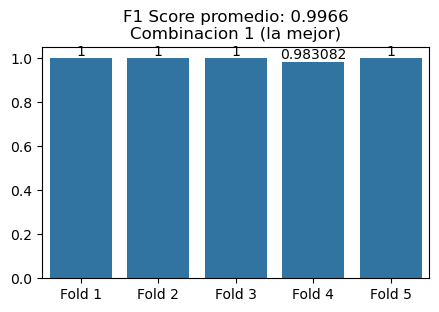

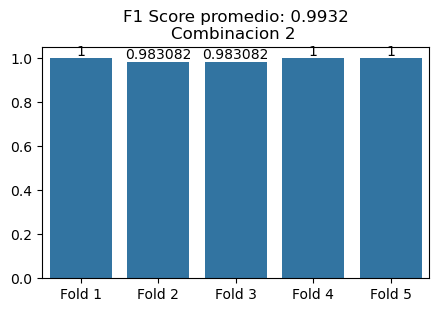

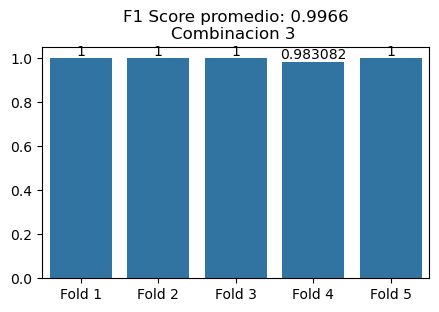

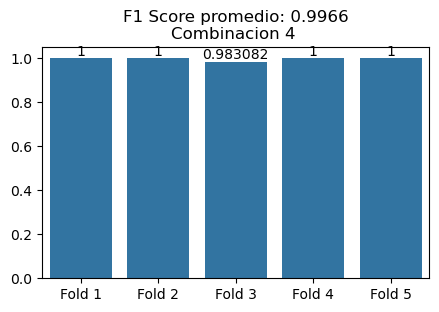

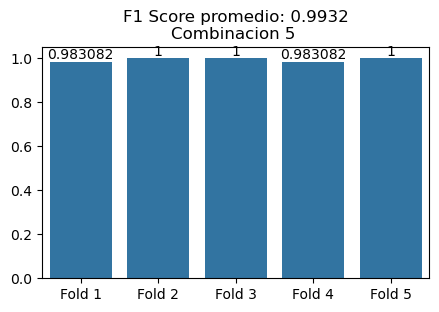

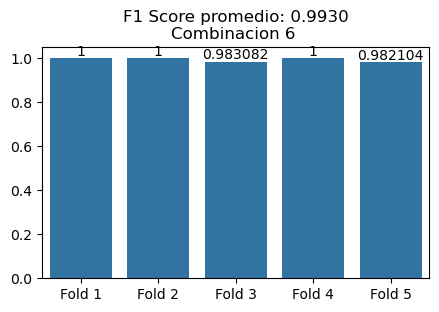


******************** ARQUITECTURA 2 ********************

Combinacion 1 de 6
	Fold 1 de 5
	Fold 2 de 5
	Fold 3 de 5
	Fold 4 de 5
	Fold 5 de 5
Combinacion 2 de 6
	Fold 1 de 5
	Fold 2 de 5
	Fold 3 de 5
	Fold 4 de 5
	Fold 5 de 5
Combinacion 3 de 6
	Fold 1 de 5
	Fold 2 de 5
	Fold 3 de 5
	Fold 4 de 5
	Fold 5 de 5
Combinacion 4 de 6
	Fold 1 de 5
	Fold 2 de 5
	Fold 3 de 5
	Fold 4 de 5
	Fold 5 de 5
Combinacion 5 de 6
	Fold 1 de 5
	Fold 2 de 5
	Fold 3 de 5
	Fold 4 de 5
	Fold 5 de 5
Combinacion 6 de 6
	Fold 1 de 5
	Fold 2 de 5
	Fold 3 de 5
	Fold 4 de 5
	Fold 5 de 5
Metrica 'F1 Score' promedio para la combinacion 1: 1.0
Metrica 'F1 Score' promedio para la combinacion 2: 1.0
Metrica 'F1 Score' promedio para la combinacion 3: 1.0
Metrica 'F1 Score' promedio para la combinacion 4: 0.9930371767371653
Metrica 'F1 Score' promedio para la combinacion 5: 1.0
Metrica 'F1 Score' promedio para la combinacion 6: 0.9966163400792375


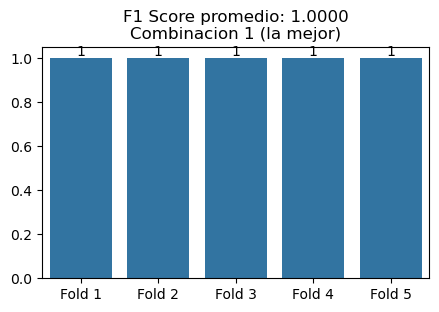

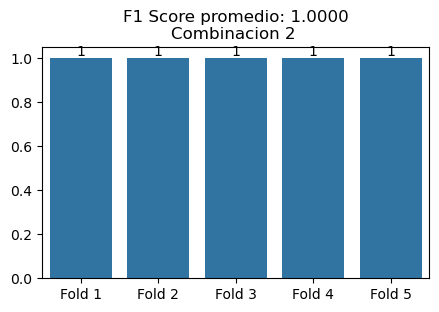

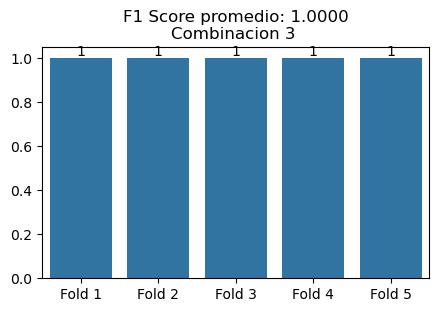

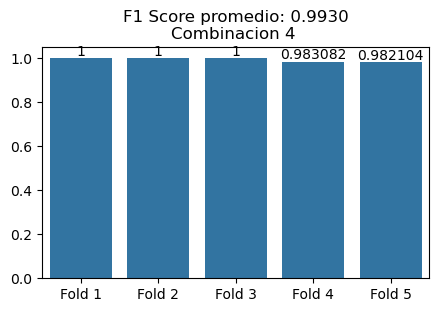

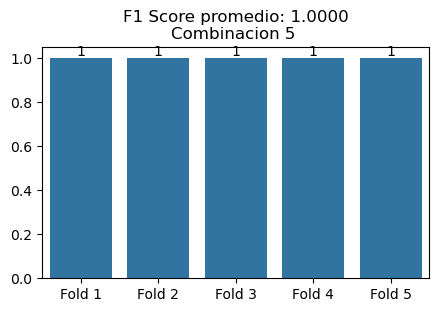

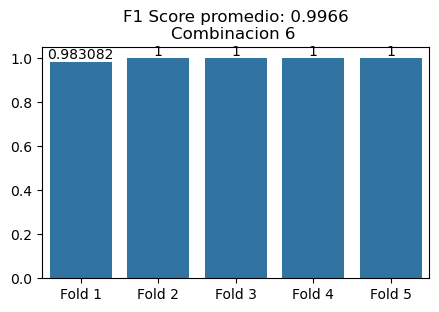

In [33]:
from sklearn.model_selection import StratifiedKFold

# Numero de clases
k=2
# Numero de caracteristicas
n=X_train.shape[1]
# Numero de folds para la estrategia 'StratifiedKFold'
n_splits=5
# Numero de epocas
epochs=100
# Tolerancia de la funcion de perdida para detener el entrenmiento si ya no hay cambios significativos
tol=1e-6
# Numero de mini batches
num_mini_batches=1

# Arquitecturas de red para probar
network_architectures=[
    [
        (5, SigmoidFunction),
        (5, SigmoidFunction),
        (5, SigmoidFunction),
        (k, SoftmaxFunction)
    ],
    [
        (30, SigmoidFunction),
        (20, SigmoidFunction),
        (k, SoftmaxFunction)
    ]
]

best_model_list=[]
best_f1_score_mean_list=[]

# Inicializacion de parametros 
def params_init(X, y, model):
    for layer in model.layers:
        layer.s_W=Some(arr=np.random.random((layer.n_input_features,layer.n_neurons)), calculate_grad=True)
        layer.s_b=Some(arr=np.random.random((layer.n_neurons,1)), calculate_grad=True)

# Iteracion por cada arquitectura de red
for architecture_it,layers_config_list in enumerate(network_architectures):
    print(f"\n{'*' * 20} ARQUITECTURA {architecture_it + 1} {'*' * 20}\n")
    # Arquitectura de la red
    layers=get_fc_layers(
        n_features=n,
        layers_config_list=layers_config_list
    )
    # Construccion del modelo
    model=Sequential(
        k=k, 
        layers=layers, 
        reset_parameters=True
    )
    
    # Para cada combinacion, se guarda la lista de scores (un score por cada fold)
    scores_by_combination_dict={}
    
    # Para cada combinacion de hiperparametros
    for i,class_parameters_combination in enumerate(class_parameters_combinations):
        print(f"Combinacion {i + 1} de {len(class_parameters_combinations)}")
        # Carga de los hiperparametros al modelo
        model.set_class_parameters(**class_parameters_combination)
        # Para una combinacion de hiperparametros, se implementa la estrategia 'StratifiedKFold' utilizando el conjunto de entrenamiento
        stratified_kfold=StratifiedKFold(n_splits=n_splits, shuffle=False, random_state=None)
        scores=[]
        """
            Sea 'k' el numero de folds.
            
            Se itera k veces con diferentes subconjuntos cada vez:
                - k - 1 subconjuntos para entrenamiento
                - 1 subconjunto para prueba
    
                Los subconjuntos se obtienen del conjunto de entrenamiento.
        """
        for j, (train_index, test_index) in enumerate(stratified_kfold.split(X_train, y_train)):
            print(f"\tFold {j + 1} de {n_splits}")
            # Datos de entrenamiento
            X_train_fold=X_train[train_index]
            y_train_fold=y_train[train_index][:,None]
            # Datos de prueba
            X_test_fold=X_train[test_index]
            y_test_fold=y_train[test_index][:,None]
            # Entrenamiento del modelo
            history,stopped=model.fit(X_train_fold, y_train_fold, params_init=params_init, epochs=epochs, tol=tol, num_mini_batches=num_mini_batches)
            # Valor de la metrica 'F1 Score' usando los datos de prueba
            score=model.score(X_test_fold, y_test_fold, metric="f1_score")
            scores.append(score)
        scores_by_combination_dict[i + 1]=scores
    
    # Eleccion de los mejores hiperparametros
    best_index=None
    best_f1_score_mean=None
    for key in scores_by_combination_dict.keys():
        f1_score_mean=np.mean(scores_by_combination_dict[key])
        print(f"Metrica 'F1 Score' promedio para la combinacion {key}: {f1_score_mean}")
        if best_index is None or f1_score_mean > best_f1_score_mean:
            best_index=int(key) - 1
            best_f1_score_mean=f1_score_mean
    
    # Mejores hiperparametros 
    best_class_parameters_combination=class_parameters_combinations[best_index]
    # Carga de los mejores hiperparametros al modelo
    model.set_class_parameters(**best_class_parameters_combination)
    best_model_list.append(model)
    
    # Mejor 'F1 Score' promedio para la arquitectura
    best_f1_score_mean_list.append(best_f1_score_mean)

    # Resultados obtenidos para cada combinacion de hiperparametros
    for key in scores_by_combination_dict.keys():
        class_parameters_combination=class_parameters_combinations[int(key) - 1]
        scores=scores_by_combination_dict[key]
        plt.figure(figsize=(5,3))
        ax = sns.barplot(x=[f"Fold {i + 1}" for i in range(len(scores))], y=scores, errorbar=None)
        ax.bar_label(ax.containers[0], fontsize=10);
        plt.title(f"F1 Score promedio: {np.mean(scores):.4f}\nCombinacion {key} {'(la mejor)' if best_index == int(key) - 1 else ''}")
        plt.show()

best_index_architecture=np.argmax(best_f1_score_mean_list)
# Mejor modelo (mejor arquitectura y mejores hiperparametros)
best_model=best_model_list[best_index_architecture]

In [34]:
# La mejor arquitectura
network_architectures[best_index_architecture]

[(30, puromachine.SigmoidFunction),
 (20, puromachine.SigmoidFunction),
 (2, puromachine.SoftmaxFunction)]

In [35]:
# La mejor combinacion de hiperparametros
# Se menciona la combinacion 1
class_parameters_combinations[1 - 1]

{'loss_function': {'name': 'cce',
  'parameters': {'weights': {'0': 1, '1': 8.987341772151899}}},
 'optimizer': {'name': 'rmsprop',
  'parameters': {'momentum': 0.5, 'learning_rate': 0.1}}}

In [36]:
# El modelo se entrena con todo el conjunto de entrenamiento
history,stopped=best_model.fit(X_train, y_train[:,None], params_init=params_init, epochs=epochs, tol=tol, num_mini_batches=num_mini_batches)

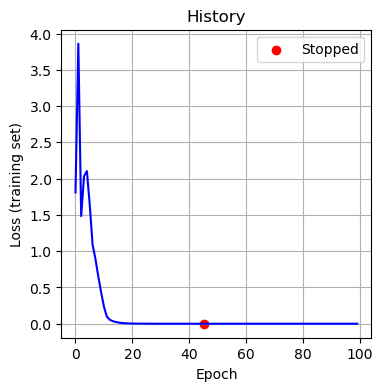

In [37]:
# Grafica del costo de la funcion de perdida a lo largo de las epocas
fig,ax=FitResults.plot_history(history, stopped, figsize=(4,4))
plt.show()

# Resultados con el conjunto de prueba
COMPARACION DE RESULTADOS.

Seleccion del mejor modelo para clasificacion binaria.

Interpretacion de las metricas:
- Sensitivity (Recall)
    - De todos los ejemplos positivos, que tanto acerto el modelo? 
- Specificity
    - De todos los ejemplos negativos, que tanto acerto el modelo? 
- Precision
    - De todas las predicciones positivas, que tanto acerto el modelo? 
- Accuracy
    - Predicciones correctas / Total 
- F1 Score
    - Es una metrica robusta que toma las metricas 'Precision' y 'Recall'.
    - Devuelve cercano a 1 si ambas son tambien cercanas a 1
    - Si una es mas grande que la otra, devuelve valores bajos
    - Si ambas son bajas, devuelve un valor cercano a 0

<img
  style="display: flex; margin: auto;"
  src="https://images.prismic.io/encord/0ef9c82f-2857-446e-918d-5f654b9d9133_Screenshot+%2849%29.png?auto=compress,format"
  width="300"
  height="300" 
/>

<img
  style="display: flex; margin: auto;"
  src="https://miro.medium.com/v2/resize:fit:969/1*d0UCCIF10Soi7VQGxdVrWQ.jpeg"
  width="700"
  height="700" 
/>

### Resultados red neuronal profunda

F1 Score: 1.0


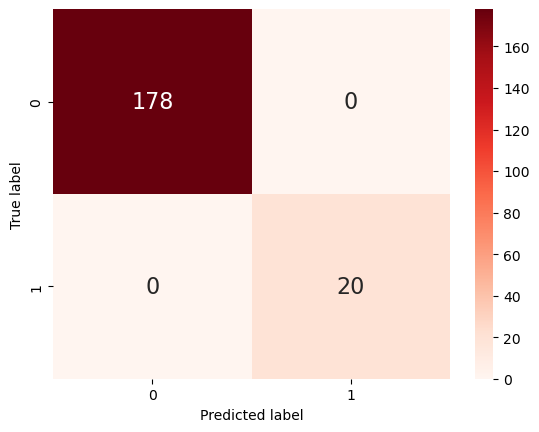

In [38]:
k=2
# Prediccion con el conjunto de prueba
pred=best_model.predict(X_test)
# Matriz de confusion
confusion_matrix=ConfusionMatrix(pred, y_test[:,None], k=k)
# Metrica 'F1 Score'
print(f"F1 Score: {confusion_matrix.get_score('f1_score')}")

# Grafica de la matriz de confusion
plot_confusion_matrix(confusion_matrix.matrix)

### CONCLUSIONES

# Guardado y carga de parametros 

In [39]:
# Ruta donde se guardaran los parametros del modelo seleccionado
models_path=os.path.join("/".join(current_path.split("/")[0:-1]), *["Project", "app", "data", "models"])
print(models_path)

/home/chuy/Practicas/PORTAFOLIO/CERTIFICADOS/Samsung Innovation Campus 2024/Proyecto/NEW PROJECT/Project/app/data/models


In [40]:
# # Guardar modelo
# best_model.save(path=models_path, file_name=selected_posture_name)

F1 Score: 1.0


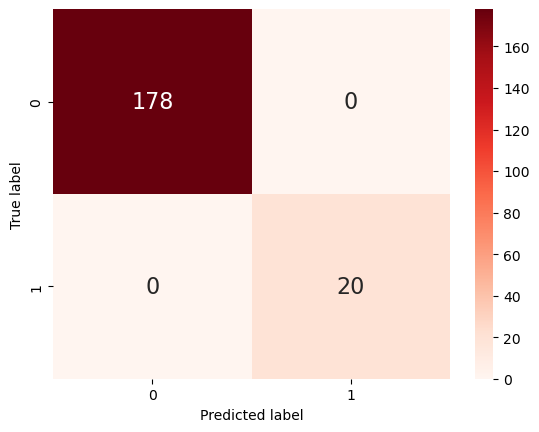

In [41]:
# Cargar modelo y ponerlo a prueba 
loaded_best_model=Sequential.load(path=models_path, file_name=selected_posture_name)

k=2
# Prediccion con el conjunto de prueba
pred=loaded_best_model.predict(X_test)
# Matriz de confusion
confusion_matrix=ConfusionMatrix(pred, y_test[:,None], k=k)
# Metrica 'F1 Score'
print(f"F1 Score: {confusion_matrix.get_score('f1_score')}")

# Grafica de la matriz de confusion
plot_confusion_matrix(confusion_matrix.matrix)